<a href="https://colab.research.google.com/github/wendyku/gender-neutral-captioning/blob/master/bertscore_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Utility functions

In [1]:
!pip install wget
import wget
wget.download('http://images.cocodataset.org/zips/train2014.zip', '')

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=2d1967a38c267ac01f350ff6de03c190aa3caaa0a3c95392f0fec866fadcf56e
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


'train2014.zip'

In [0]:
!unzip 'train2014.zip'

In [0]:
import glob
import json
import random

def get_data(image_folder_path, annotations_path, sample_size, datatype = 'train'):
    
    # Get paths of individual images
    images_path = glob.glob(f"{image_folder_path}{datatype}2014/*")
    
    # Extract a list of all images that includes human
    with open(f'{annotations_path}instances_{datatype}2014.json', encoding='utf-8') as f:
      instances_json = json.load(f)
    image_category_dict = dict()
    for i in range(len(instances_json['annotations'])):
        cat_id = instances_json['annotations'][i]['category_id']
        image_id = instances_json['annotations'][i]['image_id']
        # If we are to exclude images of more than one person
        # if instances_json['annotations'][i]['iscrowd'] == 0:
        if cat_id in image_category_dict:
            image_category_dict[cat_id] += [image_id]
        else:
            image_category_dict[cat_id] = [image_id]
    human_image_ids = set(image_category_dict[1]) #human images are of category 1, remove duplicates
    
    # Select sample out of all human images
    training_image_ids = random.sample(human_image_ids, sample_size)
    
    # Build dictionaries to map image ids to filenames and captions to images
    with open(f'{annotations_path}captions_{datatype}2014.json', encoding='utf-8') as f:
      captions_json = json.load(f)

    image_id_dict = dict()
    # key = image_id, value = image_fname
    for i in range(len(captions_json['images'])):
        image_id = captions_json['images'][i]['id']
        image_fname = captions_json['images'][i]['file_name']
        image_id_dict[image_id] = image_fname

    captions_dict = dict()
    # key = image_id, value = list of captions
    for i in range(len(captions_json['annotations'])):
        image_id = captions_json['annotations'][i]['image_id']
        caption = captions_json['annotations'][i]['caption']
        if image_id in training_image_ids and image_id in captions_dict:
            captions_dict[image_id] += [caption]
        elif image_id in training_image_ids:
            captions_dict[image_id] = [caption]
            
    return training_image_ids, images_path, image_id_dict, captions_dict

In [0]:
###### Example of selected captions
import matplotlib.pyplot as plt

image_folder_path = ''
annotations_path = ''
sample_size = 10
training_image_ids, images_path, image_id_dict, captions_dict = get_data(image_folder_path, annotations_path, sample_size)
egs = random.sample(training_image_ids, 10)
for eg in egs:
    img = plt.imread(image_folder_path + "train2014/"+ image_id_dict[eg])
    plt.imshow(img)
    plt.show()
    print(captions_dict[eg])

## Data pre-processing

In [0]:
import nltk
import pickle
from collections import Counter
nltk.download('punkt')

class Vocabulary(object):
    
    def __init__(self, captions_dict, vocab_threshold = 4,\
              start_word = '<BOS>', end_word = '<EOS>', unk_word = '<UNK>'):
        self.vocab_threshold = vocab_threshold # Minimum count of words for a word to be considered in the vocabulary
        self.start_word = start_word # Token to denote beginning of sentence, end of sentence and unknown word
        self.end_word = end_word
        self.unk_word = unk_word
        # Extract captions from captions_dict
        self.captions = []
        for sublist in captions_dict.values():
            for item in sublist:
                self.captions.append(item)
        # Initiate dictionaries to convert tokens to/from integers
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        self.get_vocab()
        self.save_vocab()
    
    def get_vocab(self):
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()
    
    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
    
    def add_captions(self):
        counter = Counter()
        for i, caption in enumerate(self.captions):
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)
            
            if i % 100 == 0:
                print(f"Tokenize captions: {i, len(self.captions)}")
        
        for word, count in counter.items():
            if count >= self.vocab_threshold:
                self.add_word(word)
    
    def save_vocab(self):
        with open('vocab.pkl', "wb") as f:
            pickle.dump(self, f)
    
    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]
    
    def __len__(self):
        return len(self.word2idx)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
import torch
import nltk
import numpy as np
import pickle
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from PIL import Image

class MyDataset(Dataset):
    
    def __init__(self, image_folder_path, annotation_path, data_type = 'train', sample_size = 100,
              vocab_threshold = 5, batch_size = 10):
        assert data_type in ['train', 'val', 'test']
        
        self.data_type = data_type
        self.image_folder_path = image_folder_path
        self.batch_size = batch_size
        self.data_type = data_type
        
        # Obtain sample of training images
        self.training_image_ids, self.images_path, self.image_id_dict, captions_dict \
        = get_data(image_folder_path, annotations_path, sample_size, data_type)
        
        # Set up vocabulary or load from training set
        if self.data_type == 'train':
            self.vocab = Vocabulary(captions_dict)
            print('Vocabulary successfully created')
        else:
            with open('vocab.pkl', "rb") as f:
                self.vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
                print('Vocabulary successfully loaded')
        
        # Set up dataset
        self.im_ids = []
        self.captions = []
        self.images = []
        self.captions_len = []
        for im_id, captions_list in captions_dict.items():
            for item in captions_list:
                self.im_ids.append(im_id)
                self.captions.append(item)
                self.captions_len.append(len(nltk.tokenize.word_tokenize(item)))
        
        # Set up paramteres for image feature extraction 
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
        ])
    
    def __getitem__(self, index):
        im_id = self.im_ids[index]
        
        # Convert image to tensor
        image = Image.open(self.image_folder_path + f"{self.data_type}2014/"+ self.image_id_dict[im_id]).convert("RGB")
        image = self.transform(image)
        
        # Tokenize captions
        tokens = nltk.tokenize.word_tokenize(str(self.captions[index]).lower())
        caption = []
        caption.append(self.vocab(self.vocab.start_word))
        caption.extend([self.vocab(token) for token in tokens])
        caption.append(self.vocab(self.vocab.end_word))
        caption = torch.Tensor(caption).long()
        
        return image, caption
    
    def get_indices(self):
        #random.seed(0)
        search_len = np.random.choice(self.captions_len)
        all_indices = np.where([self.captions_len[i] == search_len\
                for i in range(len(self.captions_len))])[0]
        indices = list(np.random.choice(all_indices, size = self.batch_size))
        return indices
    
    def __len__(self):
        return len(self.ids)
    
    

In [0]:
class TestDataset(Dataset):
    
    def __init__(self, image_folder_path, annotation_path, data_type = 'train', sample_size = 1,
              vocab_threshold = 5, batch_size = 1):
        self.image_folder_path = image_folder_path
        self.batch_size = batch_size
        self.data_type = data_type
        
        # Obtain sample of training images
        self.training_image_ids, self.images_path, self.image_id_dict, captions_dict \
        = get_data(image_folder_path, annotations_path, sample_size, data_type)
        
        # Set up vocabulary
        with open('vocab.pkl', "rb") as f:
            self.vocab = pickle.load(f)
            self.word2idx = vocab.word2idx
            self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded')
        
        # Set up dataset
        self.im_ids = []
        self.captions = []
        self.images = []
        self.captions_len = []
        for im_id, captions_list in captions_dict.items():
            for item in captions_list:
                self.im_ids.append(im_id)
                self.captions.append(item)
                self.captions_len.append(len(nltk.tokenize.word_tokenize(item)))
        
        # Set up paramteres for image feature extraction 
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
        ])
    
    def __getitem__(self, index):
        im_id = self.im_ids[index]
        
        # Convert image to tensor
        image = Image.open(self.image_folder_path + f"{self.data_type}2014/"+ self.image_id_dict[im_id]).convert("RGB")
        original_image = np.array(image)
        transformed_image = self.transform(image)
        
        return original_image, transformed_image
    
    def get_indices(self):
        #random.seed(0)
        search_len = np.random.choice(self.captions_len)
        all_indices = np.where([self.captions_len[i] == search_len\
                for i in range(len(self.captions_len))])[0]
        indices = list(np.random.choice(all_indices, size = self.batch_size))
        return indices
    
    def __len__(self):
        return len(self.im_ids)

In [0]:
def load_data(image_folder_path, annotations_path, data_type, sample_size):
    # Initiate instance of MyDataset class
    num_workers = 0
    dataset = MyDataset(image_folder_path, annotations_path, data_type, sample_size)
    indices = dataset.get_indices()
    initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
    data_loader = data.DataLoader(dataset=dataset, num_workers=num_workers,\
                  batch_sampler=\
                 data.sampler.BatchSampler(sampler=initial_sampler,\
                 batch_size=dataset.batch_size,drop_last=False))
    
    return data_loader
    

In [0]:
def load_test_data(image_folder_path, annotations_path, data_type):
    # Initiate instance of MyDataset class
    num_workers = 0
    dataset = TestDataset(image_folder_path, annotations_path, data_type)
    data_loader = data.DataLoader(dataset=dataset, num_workers=num_workers,\
                 batch_size=dataset.batch_size, shuffle = True)
    
    return data_loader

## Encoder CNN and Decoder RNN setup

In [0]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn import functional as f

In [0]:
class EncoderCNN(nn.Module):
    
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        # Use pretrained ResNet-50 weights
        res = models.resnet50(pretrained = True)
        modules = list(res.children())[:-1]
        self.res = nn.Sequential(*modules)
        self.embed = nn.Linear(res.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum = 0.01)
    
    def forward(self, images):
        # Extract feature vectors from image inputs
        with torch.no_grad():
            features = self.res(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        features = self.bn(features)
        return features


In [0]:
class DecoderRNN(nn.Module):
    
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers = 1):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, features, captions):
        # Decode image feature vectors to generate captions
        captions = captions [:, :-1]
        embeddings = self.embed(captions)
        inputs = torch.cat((features.unsqueeze(1), embeddings), 1)
        hiddens, _ = self.lstm(inputs)
        output = self.linear(hiddens)
        return output
    
    def sample_beam_search (self, inputs, states = None, max_len = 20, beam_width = 5):
        # Beam search approach
        # Accept a pre-processed image tensor and return top predicted sentences
        # Top sentences in indices and their corresponding inputs and states
        idx_sequences = [[[], 0.0, inputs, states]]
        
        for _ in range(max_len):
            all_candidates = []
            # Predict next word for each top sequences
            for idx_seq in idx_sequences:
                hiddens, states = self.lstm(idx_seq[2], idx_seq[3])
                outputs = self.linear(hiddens.squeeze(1))
                log_p = f.log_softmax(outputs, -1)
                top_log_p, top_idx = log_p.topk(beam_width, 1)
                top_idx = top_idx.squeeze(0)
                for i in range(beam_width):
                    next_idx_seq, log_p = idx_seq[0][:], idx_seq[1]
                    next_idx_seq.append(top_idx[i].item())
                    log_p += top_log_p[0][i].item()
                    inputs = self.embed(top_idx[i].unsqueeze(0).unsqueeze(0))
                    all_candidates.append([next_idx_seq, log_p, inputs, states])
            sort_candidates = sorted(all_candidates, key = lambda x: x[1], reverse = True)
            idx_sequences = sort_candidates[:beam_width]
        return [idx_seq[0] for idx_seq in idx_sequences]     
        
        

## Utility functions for Model Training

In [0]:
import torch
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import time
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Determine how often to print the batch loss while training/validating. 
# We set this at `100` to avoid clogging the notebook.
PRINT_EVERY = 100

def train(train_loader, encoder, decoder, criterion, optimizer, vocab_size,
          epoch, total_step, start_step=1, start_loss=0.0):
    """Train the model for one epoch using the provided parameters. Save 
    checkpoints every 100 steps. Return the epoch's average train loss."""

    # Switch to train mode
    encoder.train()
    decoder.train()

    # Keep track of train loss
    total_loss = start_loss

    # Start time for every 100 steps
    start_train_time = time.time()

    for i_step in range(start_step, total_step + 1):
        # Randomly sample a caption length, and sample indices with that length
        indices = train_loader.dataset.get_indices()
        # Create a batch sampler to retrieve a batch with the sampled indices
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        train_loader.batch_sampler.sampler = new_sampler

        # Obtain the batch
        for batch in train_loader:
            images, captions = batch[0], batch[1]
            break 
        # Move to GPU if CUDA is available
        if torch.cuda.is_available():
            images = images.cuda()
            captions = captions.cuda()
        # Pass the inputs through the CNN-RNN model
        features = encoder(images)
        outputs = decoder(features, captions)

        # Calculate the batch loss
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        # Zero the gradients. Since the backward() function accumulates 
        # gradients, and we don’t want to mix up gradients between minibatches,
        # we have to zero them out at the start of a new minibatch
        optimizer.zero_grad()
        # Backward pass to calculate the weight gradients
        loss.backward()
        # Update the parameters in the optimizer
        optimizer.step()

        total_loss += loss.item()

        # Get training statistics
        stats = "Epoch %d, Train step [%d/%d], %ds, Loss: %.4f, Perplexity: %5.4f" \
                % (epoch, i_step, total_step, time.time() - start_train_time,
                   loss.item(), np.exp(loss.item()))
        # Print training statistics (on same line)
        print("\r" + stats, end="")
        sys.stdout.flush()

        # Print training stats (on different line), reset time and save checkpoint
        if i_step % PRINT_EVERY == 0:
            print("\r" + stats)
            filename = os.path.join("./models", "train-model-{}{}.pkl".format(epoch, i_step))
            save_checkpoint(filename, encoder, decoder, optimizer, total_loss, epoch, i_step)
            start_train_time = time.time()
            
    return total_loss / total_step
            
def validate(val_loader, encoder, decoder, criterion, vocab, epoch, 
             total_step, start_step=1, start_loss=0.0, start_bleu=0.0):
    """Validate the model for one epoch using the provided parameters. 
    Return the epoch's average validation loss and Bleu-4 score."""

    # Switch to validation mode
    encoder.eval()
    decoder.eval()

    # Initialize smoothing function
    smoothing = SmoothingFunction()

    # Keep track of validation loss and Bleu-4 score
    total_loss = start_loss
    total_bleu_4 = start_bleu

    # Start time for every 100 steps
    start_val_time = time.time()

    # Disable gradient calculation because we are in inference mode
    with torch.no_grad():
        for i_step in range(start_step, total_step + 1):
            # Randomly sample a caption length, and sample indices with that length
            indices = val_loader.dataset.get_indices()
            # Create a batch sampler to retrieve a batch with the sampled indices
            new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
            val_loader.batch_sampler.sampler = new_sampler

            # Obtain the batch
            for batch in val_loader:
                images, captions = batch[0], batch[1]
                break 

            # Move to GPU if CUDA is available
            if torch.cuda.is_available():
                images = images.cuda()
                captions = captions.cuda()
            
            # Pass the inputs through the CNN-RNN model
            features = encoder(images)
            outputs = decoder(features, captions)

            # Calculate the total Bleu-4 score for the batch
            batch_bleu_4 = 0.0
            # Iterate over outputs. Note: outputs[i] is a caption in the batch
            # outputs[i, j, k] contains the model's predicted score i.e. how 
            # likely the j-th token in the i-th caption in the batch is the 
            # k-th token in the vocabulary.
            for i in range(len(outputs)):
                predicted_ids = []
                for scores in outputs[i]:
                    # Find the index of the token that has the max score
                    predicted_ids.append(scores.argmax().item())
                # Convert word ids to actual words
                predicted_word_list = word_list(predicted_ids, vocab)
                caption_word_list = word_list(captions[i].numpy(), vocab)
                print(predicted_word_list)
                print(caption_word_list, type(caption_word_list))
                # Calculate Bleu-4 score and append it to the batch_bleu_4 list
                batch_bleu_4 += sentence_bleu([caption_word_list], 
                                               predicted_word_list, 
                                               smoothing_function=smoothing.method1)
            total_bleu_4 += batch_bleu_4 / len(outputs)

            # Calculate the batch loss
            loss = criterion(outputs.view(-1, len(vocab)), captions.view(-1))
            total_loss += loss.item()
            
            # Get validation statistics
            stats = "Epoch %d, Val step [%d/%d], %ds, Loss: %.4f, Perplexity: %5.4f, Bleu-4: %.4f" \
                    % (epoch, i_step, total_step, time.time() - start_val_time,
                       loss.item(), np.exp(loss.item()), batch_bleu_4 / len(outputs))

            # Print validation statistics (on same line)
            print("\r" + stats, end="")
            sys.stdout.flush()

            # Print validation statistics (on different line) and reset time
            if i_step % PRINT_EVERY == 0:
                print("\r" + stats)
                filename = os.path.join("./models", "val-model-{}{}.pkl".format(epoch, i_step))
                save_val_checkpoint(filename, encoder, decoder, total_loss, total_bleu_4, epoch, i_step)
                start_val_time = time.time()
                
        return total_loss / total_step, total_bleu_4 / total_step

def save_checkpoint(filename, encoder, decoder, optimizer, total_loss, epoch, train_step=1):
    """Save the following to filename at checkpoints: encoder, decoder,
    optimizer, total_loss, epoch, and train_step."""
    torch.save({"encoder": encoder.state_dict(),
                "decoder": decoder.state_dict(),
                "optimizer" : optimizer.state_dict(),
                "total_loss": total_loss,
                "epoch": epoch,
                "train_step": train_step,
               }, filename)

def save_val_checkpoint(filename, encoder, decoder, total_loss,
    total_bleu_4, epoch, val_step=1):
    """Save the following to filename at checkpoints: encoder, decoder,
    total_loss, total_bleu_4, epoch, and val_step"""
    torch.save({"encoder": encoder.state_dict(),
                "decoder": decoder.state_dict(),
                "total_loss": total_loss,
                "total_bleu_4": total_bleu_4,
                "epoch": epoch,
                "val_step": val_step,
               }, filename)

def save_epoch(filename, encoder, decoder, optimizer, train_losses, val_losses, 
               val_bleu, val_bleus, epoch):
    """Save at the end of an epoch. Save the model's weights along with the 
    entire history of train and validation losses and validation bleus up to 
    now, and the best Bleu-4."""
    torch.save({"encoder": encoder.state_dict(),
                "decoder": decoder.state_dict(),
                "optimizer": optimizer.state_dict(),
                "train_losses": train_losses,
                "val_losses": val_losses,
                "val_bleu": val_bleu,
                "val_bleus": val_bleus,
                "epoch": epoch
               }, filename)

def early_stopping(val_bleus, patience=3):
    """Check if the validation Bleu-4 scores no longer improve for 3 
    (or a specified number of) consecutive epochs."""
    # The number of epochs should be at least patience before checking
    # for convergence
    if patience > len(val_bleus):
        return False
    latest_bleus = val_bleus[-patience:]
    # If all the latest Bleu scores are the same, return True
    if len(set(latest_bleus)) == 1:
        return True
    max_bleu = max(val_bleus)
    if max_bleu in latest_bleus:
        # If one of recent Bleu scores improves, not yet converged
        if max_bleu not in val_bleus[:len(val_bleus) - patience]:
            return False
        else:
            return True
    # If none of recent Bleu scores is greater than max_bleu, it has converged
    return True

def word_list(word_idx_list, vocab):
    """Take a list of word ids and a vocabulary from a dataset as inputs
    and return the corresponding words as a list.
    """
    word_list = []
    for i in range(len(word_idx_list)):
        vocab_id = word_idx_list[i]
        word = vocab.idx2word[vocab_id]
        if word == vocab.end_word:
            break
        if word != vocab.start_word:
            word_list.append(word)
    return word_list

def clean_sentence(word_idx_list, vocab):
    """Take a list of word ids and a vocabulary from a dataset as inputs
    and return the corresponding sentence (as a single Python string).
    """
    sentences = []
    for i in range(len(word_idx_list)):
        sentence = []
        for vocab_id in word_idx_list[i]:
            word = vocab.idx2word[vocab_id]
            if word == vocab.end_word:
                break
            if word != vocab.start_word:
                sentence.append(word)
        sentence = " ".join(sentence)
        sentences.append(sentence)
    return sentences

def get_prediction(data_loader, encoder, decoder, vocab):
    """Loop over images in a dataset and print model's top three predicted 
    captions using beam search."""
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title("Sample Image")
    plt.show()
    if torch.cuda.is_available():
        image = image.cuda()
    features = encoder(image).unsqueeze(1)
    #print ("Caption without beam search:")
    #output = decoder.sample(features)
    #sentence = clean_sentence(output, vocab)
    #print (sentence)

    print ("Top captions using beam search:")
    outputs = decoder.sample_beam_search(features)
    # Print maximum the top 3 predictions
    num_sents = min(len(outputs), 3)
    for output in outputs[:num_sents]:
        sentence = clean_sentence(output, vocab)
        print (sentence)

## Train Model

In [0]:
import torch
import torch.nn as nn
import math
from torch.autograd import Variable
import torch.utils.data as data
import numpy as np
import os
import requests
import time

In [0]:
image_folder_path = ''
annotations_path = ''
train_loader = load_data(image_folder_path, annotations_path,\
                         data_type = 'train', sample_size = 10)
val_loader = load_data(image_folder_path, annotations_path,\
                       data_type = 'train', sample_size = 2)

Tokenize captions: (0, 50)
Vocabulary successfully created
Tokenize captions: (0, 10)
Vocabulary successfully created


In [0]:
# Sample a subset of captions with a randomized length
indices = train_loader.dataset.get_indices()

# Create and assign batch sampler to retrieve a batch with the sampled indices
new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
train_loader.batch_sampler.sampler = new_sampler
    
# Load one batch
# images, captions = next(iter(data_loader))

# Obtain the batch
for batch in train_loader:
    images, captions = batch[0], batch [1]
    
print('images.shape:', images.shape)
print('captions.shape:', captions.shape)

images.shape: torch.Size([10, 3, 224, 224])
captions.shape: torch.Size([10, 15])


In [0]:
batch_size = 32
embed_size = 256
hidden_size = 512
num_epochs = 10
vocab_size = len(train_loader.dataset.vocab)

# Initialize CNN and RNN
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Use GPU if available
if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()

# Define the loss function
criterion = nn.CrossEntropyLoss().cuda()\
if torch.cuda.is_available() else nn.CrossEntropyLoss()

# Specify the learnable parameters of the model
params = list(decoder.parameters()) + list(encoder.embed.parameters()) + list(encoder.bn.parameters())

# Define the optimizer
optimizer = torch.optim.Adam(params=params, lr=0.001)

In [0]:
import math
# Calculate total number of training steps per epoch
total_train_step = math.ceil(len(train_loader.dataset.captions_len) / train_loader.batch_sampler.batch_size)
print ("Number of training steps:", total_train_step)
total_val_step = math.ceil(len(val_loader.dataset.captions_len) / val_loader.batch_sampler.batch_size)
print ("Number of training steps:", total_val_step)


Number of training steps: 5
Number of training steps: 1


In [0]:
train_losses = []
val_losses = []
val_bleus = []
best_val_bleu = float("-INF")

start_time = time.time()
for epoch in range(1, num_epochs + 1):
    train_loss = train(train_loader, encoder, decoder, criterion, optimizer, 
                       vocab_size, epoch, total_train_step)
    train_losses.append(train_loss)
    val_loss, val_bleu = validate(val_loader, encoder, decoder, criterion,
                                  train_loader.dataset.vocab, epoch, total_val_step)
    val_losses.append(val_loss)
    val_bleus.append(val_bleu)
    if val_bleu > best_val_bleu:
        print ("Validation Bleu-4 improved from {:0.4f} to {:0.4f}, saving model to best-model.pkl".
               format(best_val_bleu, val_bleu))
        best_val_bleu = val_bleu
        filename = os.path.join("", "best-model.pkl")
        save_epoch(filename, encoder, decoder, optimizer, train_losses, val_losses, 
                   val_bleu, val_bleus, epoch)
    else:
        print ("Validation Bleu-4 did not improve, saving model to model-{}.pkl".format(epoch))
    # Save the entire model anyway, regardless of being the best model so far or not
    filename = os.path.join("", "model-{}.pkl".format(epoch))
    save_epoch(filename, encoder, decoder, optimizer, train_losses, val_losses, 
               val_bleu, val_bleus, epoch)
    print ("Epoch [%d/%d] took %ds" % (epoch, num_epochs, time.time() - start_time))
    if epoch > 5:
        # Stop if the validation Bleu doesn't improve for 3 epochs
        if early_stopping(val_bleus, 3):
            break
    start_time = time.time()

Epoch 1, Val step [1/1], 2s, Loss: 2.0408, Perplexity: 7.6970, Bleu-4: 0.4011Validation Bleu-4 improved from -inf to 0.4011, saving model to best-model.pkl
Epoch [1/10] took 15s
Epoch 2, Val step [1/1], 2s, Loss: 2.0556, Perplexity: 7.8114, Bleu-4: 0.4905Validation Bleu-4 improved from 0.4011 to 0.4905, saving model to best-model.pkl
Epoch [2/10] took 15s
Epoch 3, Val step [1/1], 2s, Loss: 2.5383, Perplexity: 12.6580, Bleu-4: 0.3257Validation Bleu-4 did not improve, saving model to model-3.pkl
Epoch [3/10] took 15s
Epoch 4, Val step [1/1], 2s, Loss: 2.6666, Perplexity: 14.3914, Bleu-4: 0.2612Validation Bleu-4 did not improve, saving model to model-4.pkl
Epoch [4/10] took 15s
Epoch 5, Val step [1/1], 2s, Loss: 2.6833, Perplexity: 14.6328, Bleu-4: 0.2310Validation Bleu-4 did not improve, saving model to model-5.pkl
Epoch [5/10] took 15s
Epoch 6, Val step [1/1], 2s, Loss: 1.9748, Perplexity: 7.2048, Bleu-4: 0.4363Validation Bleu-4 did not improve, saving model to model-6.pkl
Epoch [6/10] 

## Generate Captions

In [0]:
import os
from torchvision import transforms
import torch
import numpy as np
import matplotlib.pyplot as plt

Vocabulary successfully loaded
Vocabulary successfully loaded


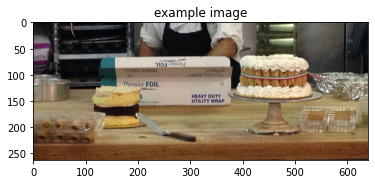

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


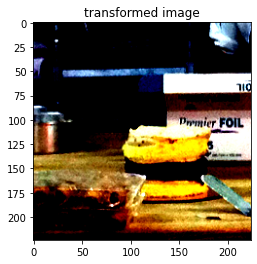

In [0]:
with open('vocab.pkl', "rb") as f:
    vocab = pickle.load(f)
    word2idx = vocab.word2idx
    idx2word = vocab.idx2word
    print('Vocabulary successfully loaded')


test_loader = load_test_data(image_folder_path, annotations_path, 'train')
original_image, image = next(iter(test_loader))
transformed_image = image.numpy()
transformed_image = np.squeeze(transformed_image)\
                    .transpose((1, 2, 0))

# Print sample image, before and after pre-processing
plt.imshow(np.squeeze(original_image))
plt.title('example image')
plt.show()
plt.imshow(transformed_image)
plt.title('transformed image')
plt.show()

In [0]:
# Load the most recent checkpoint
checkpoint = torch.load(os.path.join('', 'best-model.pkl'))

# Specify values for embed_size and hidden_size - we use the same values as in training step
embed_size = 256
hidden_size = 512

# Get the vocabulary and its size
vocab = test_loader.dataset.vocab
vocab_size = len(vocab)

# Initialize the encoder and decoder, and set each to inference mode
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the pre-trained weights
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])

# Move models to GPU if CUDA is available.
if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()

features = encoder(image).unsqueeze(1)
output = decoder.sample_beam_search(features)
print('example output:', output)

In [0]:
sentences = clean_sentence(output, vocab)
print('example sentence: \n')
for sentence in set(sentences):
    print(f'{sentence}')

In [0]:
!pip install bert_score

In [0]:
from bert_score import score
def validate_bert(val_loader, encoder, decoder, criterion, vocab, epoch, 
             total_step, start_step=1, start_loss=0.0, start_bert=0.0):
    """Validate the model for one epoch using the provided parameters. 
    Return the epoch's average validation loss and Bleu-4 score."""

    # Switch to validation mode
    encoder.eval()
    decoder.eval()

    # Keep track of validation loss and Bert score
    total_loss = start_loss
    total_bert = start_bert

    # Start time for every 100 steps
    start_val_time = time.time()

    # Disable gradient calculation because we are in inference mode
    with torch.no_grad():
        for i_step in range(start_step, total_step + 1):
            # Randomly sample a caption length, and sample indices with that length
            indices = val_loader.dataset.get_indices()
            # Create a batch sampler to retrieve a batch with the sampled indices
            new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
            val_loader.batch_sampler.sampler = new_sampler

            # Obtain the batch
            for batch in val_loader:
                images, captions = batch[0], batch[1]
                break 

            # Move to GPU if CUDA is available
            if torch.cuda.is_available():
                images = images.cuda()
                captions = captions.cuda()
            
            # Pass the inputs through the CNN-RNN model
            features = encoder(images)
            outputs = decoder(features, captions)

            # Calculate the total Bert score for the batch
            batch_bert = 0.0
            # Iterate over outputs. Note: outputs[i] is a caption in the batch
            # outputs[i, j, k] contains the model's predicted score i.e. how 
            # likely the j-th token in the i-th caption in the batch is the 
            # k-th token in the vocabulary.
            for i in range(len(outputs)):
                predicted_ids = []
                for scores in outputs[i]:
                    # Find the index of the token that has the max score
                    predicted_ids.append(scores.argmax().item())
                # Convert word ids to actual words
                predicted_caption = [' '.join(word_list(predicted_ids, vocab))]
                caption = [' '.join(word_list(captions[i].numpy(), vocab))]
                # print(predicted_caption, caption)
                # Calculate Bert score and append it to the batch_bert list
                P, R, f1 = score(predicted_caption,caption, lang='en', rescale_with_baseline=True)
                print(f1)
                batch_bert += f1
            total_bert += batch_bert / len(outputs)

            # Calculate the batch loss
            loss = criterion(outputs.view(-1, len(vocab)), captions.view(-1))
            total_loss += loss.item()
            
            # Get validation statistics
            stats = "Epoch %d, Val step [%d/%d], %ds, Loss: %.4f, Perplexity: %5.4f, Bert-Score: %.4f" \
                    % (epoch, i_step, total_step, time.time() - start_val_time,
                       loss.item(), np.exp(loss.item()), batch_bert / len(outputs))

            # Print validation statistics (on same line)
            print("\r" + stats, end="")
            sys.stdout.flush()

            # Print validation statistics (on different line) and reset time
            if i_step % PRINT_EVERY == 0:
                print("\r" + stats)
                filename = os.path.join("./models", "val-model-{}{}.pkl".format(epoch, i_step))
                save_val_checkpoint(filename, encoder, decoder, total_loss, total_bert, epoch, i_step)
                start_val_time = time.time()
                
        return total_loss / total_step, total_bert / total_step


In [0]:
train_losses = []
val_losses = []
val_bscore = []
best_val_bscore = float("-INF")

start_time = time.time()
for epoch in range(1, num_epochs + 1):
    train_loss = train(train_loader, encoder, decoder, criterion, optimizer, 
                       vocab_size, epoch, total_train_step)
    train_losses.append(train_loss)
    val_loss, val_bscore = validate_bert(val_loader, encoder, decoder, criterion,
                                  train_loader.dataset.vocab, epoch, total_val_step)
    val_losses.append(val_loss)
    val_bscores.append(val_bscore)
    if val_bscore > best_val_bscore:
        print ("Validation bscore improved from {:0.4f} to {:0.4f}, saving model to best-model.pkl".
               format(best_val_bscore, val_bscore))
        best_val_bscore = val_bscore
        filename = os.path.join("", "best-model.pkl")
        save_epoch(filename, encoder, decoder, optimizer, train_losses, val_losses, 
                   val_bscore, val_bscores, epoch)
    else:
        print ("Validation bscore did not improve, saving model to model-{}.pkl".format(epoch))
    # Save the entire model anyway, regardless of being the best model so far or not
    filename = os.path.join("", "model-bert-{}.pkl".format(epoch))
    save_epoch(filename, encoder, decoder, optimizer, train_losses, val_losses, 
               val_bscore, val_bscores, epoch)
    print ("Epoch [%d/%d] took %ds" % (epoch, num_epochs, time.time() - start_time))
    if epoch > 5:
        # Stop if the validation bscore doesn't improve for 3 epochs
        if early_stopping(val_bscores, 3):
            break
    start_time = time.time()